## Heat Equation
#### Parameter estimation for the heat equation (no source) using Gaussian processes (Backward Euler scheme)


#### Problem Setup

$u_t - \alpha u_{xx} = 0$

$u(x,t) = e^{-t}sin(\frac{x}{\sqrt{\alpha}})$

$u_0(x) := u(x,0) = sin(\frac{x}{\sqrt{\alpha}})$

$x \in [0, 2\pi \sqrt{\alpha}], t \in [0,1]$

Using the backward Euler scheme, the equation can be re-written as:

$\frac{u_n - u_{n-1}}{\tau} - \alpha \frac{d^2}{dx^2}u_n = 0$

and so:

$u_n - \tau \alpha \frac{d^2}{dx^2}u_n = u_{n-1}$


Consider $u_n$ to be a Gaussian processes.

$u_n \sim \mathcal{GP}(0, k_{uu}(x_i, x_j, \theta))$

And the linear operator:

$\mathcal{L}_x^\alpha = \cdot - \tau \alpha \frac{d^2}{dx^2}\cdot$

so that

$\mathcal{L}_x^\alpha u_n = u_{n-1}$

Problem at hand: estimate $\alpha$.

For the sake of simplicity, take $u := u_n$ and $f := u_{n-1}$.


#### step 1: Simulate data

Take data points at $t = 0$ for $(u_{n-1})$ and $t = \tau$ for $(u_n)$, where $\tau$ is the time step.

$\alpha = 1$ and $x \in (0,2\pi)$.

In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
tau = 0.2
def get_simulated_data(tau_param, alpha_param):
    x = 2*np.pi*np.sqrt(alpha_param)*np.random.rand(20)
    y_u = np.exp(-tau_param)*np.sin(x/np.sqrt(alpha_param))
    y_f = np.sin(x/np.sqrt(alpha_param))
    return (x, y_u, y_f)

(x, yu, yf) = get_simulated_data(tau, 1)

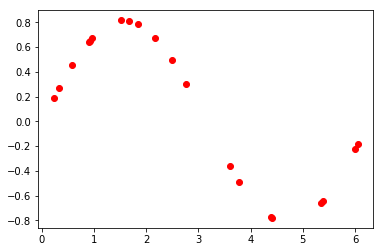

In [3]:
plt.plot(x, yu, 'ro')
plt.show()

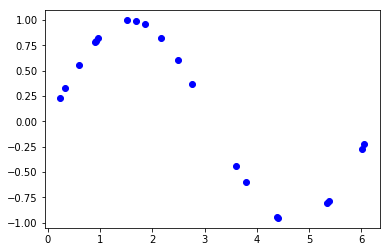

In [4]:
plt.plot(x, yf, 'bo')
plt.show()

#### Step 2:Evaluate kernels

$k_{uu}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2}(x_i-x_j)^2)$

In [5]:
x_i, x_j, theta, alpha = sp.symbols('x_i x_j theta alpha')
kuu_sym = theta*sp.exp(-1/(2)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta), kuu_sym, "numpy")
def kuu(x, theta):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta)
    return k

$k_{ff}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\phi \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
= \mathcal{L}_{x_i}^\phi \left( k_{uu} - \tau \alpha \frac{\partial^2}{\partial x_j^2}k_{uu} \right) \\
 = k_{uu} - \tau \alpha \left( \frac{\partial^2}{\partial x_j^2} + \frac{\partial^2}{\partial x_i^2} \right)k_{uu} + \tau^2 \alpha^2 \frac{\partial^2}{\partial x_i^2}\frac{\partial^2}{\partial x_j^2}k_{uu}$

In [6]:
kff_sym = kuu_sym \
        - tau*alpha*(sp.diff(kuu_sym, x_j, x_j) \
        + sp.diff(kuu_sym, x_i, x_i)) \
        + tau**2*alpha**2*sp.diff(kuu_sym, x_j, x_j, x_i, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, alpha), kff_sym, "numpy")
def kff(x, theta, alpha):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, alpha)
    return k

$k_{fu}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\alpha k_{uu}(x_i, x_j; \theta) \\
= k_{uu} - \tau \alpha \frac{\partial^2}{\partial x_i^2}k_{uu} $

In [7]:
kfu_sym = kuu_sym - tau*alpha*sp.diff(kuu_sym, x_i, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, alpha), kfu_sym, "numpy")
def kfu(x, theta, alpha):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], theta, alpha)
    return k

In [8]:
def kuf(x, theta, alpha):
    return kfu(x,theta,alpha).T

#### Step 3: Compute NLML

In [9]:
def nlml(params, x, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [kuu(x, params[0]) + s*np.identity(x.size), kuf(x, params[0], params[1])],
        [kfu(x, params[0], params[1]), kff(x, params[0], params[1]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [10]:
nlml((-0.5, 0), x, yu, yf, 1e-6)

214.20663351001247

#### Step 4: Optimise hyperparameters

##### Comparison of different optimisers

In [11]:
%%timeit
minimize(nlml, np.random.rand(2), args=(x, yu, yf, 1e-6), method="Nelder-Mead")

2.65 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
nlml_wp = lambda params: nlml(params, x, yu, yf, 1e-6)
param_bounds = np.array([[-3,0], [-5,1]])
%timeit minimize(nlml_wp, np.random.rand(2), method="TNC", bounds = param_bounds)

The slowest run took 5.85 times longer than the fastest. This could mean that an intermediate result is being cached.
7.37 s ± 3.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Take minimum over multiple optimisations

In [13]:
def minimize_restarts(x, y_u, y_f, n = 10):
    nlml_wp = lambda params: nlml(params, x, y_u, y_f, 1e-6)
    all_results = []
    for it in range(0,n):
        all_results.append(minimize(nlml_wp, np.random.rand(2), method="Nelder-Mead"))
    filtered_results = [m for m in all_results if 0 == m.status]
    return min(filtered_results, key = lambda x: x.fun)

In [14]:
a = minimize_restarts(x, yu, yf)

In [15]:
a

 final_simplex: (array([[-1.91262025,  0.10228481],
       [-1.91268019,  0.10228458],
       [-1.91268472,  0.10228511]]), array([-193.41696227, -193.41696227, -193.41696226]))
           fun: -193.4169622748442
       message: 'Optimization terminated successfully.'
          nfev: 118
           nit: 60
        status: 0
       success: True
             x: array([-1.91262025,  0.10228481])

##### Estimated value of $\alpha$

In [16]:
np.exp(a.x[1])

1.1076989062041889

### Some analysis [to-do]

##### Predicted values of $\alpha$ against time steps.

[this is not working as expected. the error is probably because of the mixing between local-global variables]

In [17]:
tau_val = np.array([0.2, 0.1, 0.02, 0.01, 0.002, 0.001])
alpha_est = np.zeros(tau_val.size)
alpha_sim = 1

In [18]:
for i in np.arange(tau_val.size):
    (loop_x, loop_yu, loop_yf) = get_simulated_data(tau_val[i], alpha_sim)
    a = minimize_restarts(loop_x, loop_yu, loop_yf)
    alpha_est[i] = np.exp(a.x[1])

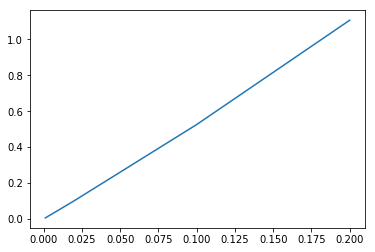

In [19]:
plt.plot(tau_val, alpha_est)
plt.show()

In [20]:
alpha_est

array([1.10698052, 0.52560495, 0.10103834, 0.05024151, 0.00994848,
       0.00489536])

##### Convergence plot

In [21]:
fn_values_convergence = []
def callback_fn(params):
    global fn_values_convergence
    fn_values_convergence.append(nlml_wp(params))


minimize(nlml_wp, np.random.rand(2), method="Nelder-Mead", callback=callback_fn)

 final_simplex: (array([[-1.9125754 ,  0.10228521],
       [-1.91265367,  0.10228597],
       [-1.91266492,  0.10228357]]), array([-193.41696225, -193.41696221, -193.41696221]))
           fun: -193.41696225113878
       message: 'Optimization terminated successfully.'
          nfev: 120
           nit: 61
        status: 0
       success: True
             x: array([-1.9125754 ,  0.10228521])

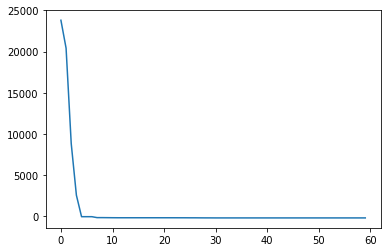

In [25]:
plt.plot(fn_values_convergence)
plt.show()